In [1]:
# This tutorial is from: https://www.ritchievink.com/blog/2019/06/10/bayesian-inference-how-we-are-able-to-chase-the-posterior/ 

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import pymc3 as pm
import theano

import pyro
import pyro.optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
import pyro.poutine as poutine
import torch
import torch.distributions.constraints as constraints
import argparse
import logging

In [2]:
lengths = np.array([195, 182])

In [3]:
# lets create a grid of our two parameters
mu = np.linspace(150, 250)
sigma = np.linspace(0, 15)[::-1]

mm, ss = np.meshgrid(mu, sigma)  # just broadcasted parameters

Text(0, 0.5, '$\\sigma$')

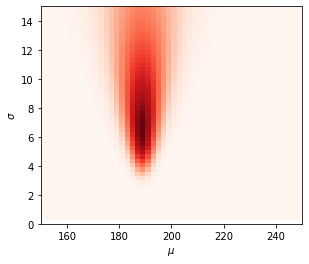

In [4]:
likelihood = stats.norm(mm, ss).pdf(lengths[0]) * stats.norm(mm, ss).pdf(lengths[1])
aspect = mm.max() / ss.max() / 3
extent = [mm.min(), mm.max(), ss.min(), ss.max()]
# extent = left right bottom top

plt.imshow(likelihood, cmap='Reds', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

Text(0, 0.5, '$\\sigma$')

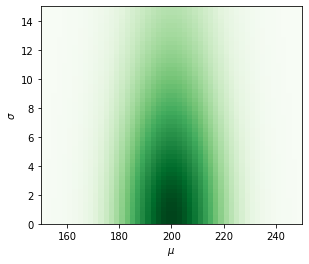

In [5]:
prior = stats.norm(200, 15).pdf(mm) * stats.cauchy(0, 10).pdf(ss)

plt.imshow(prior, cmap='Greens', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

Text(0, 0.5, '$\\sigma$')

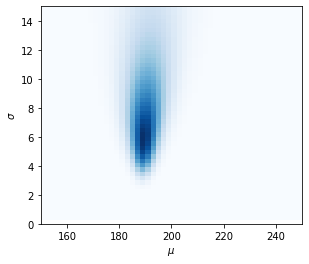

In [6]:
# Define the posterior 
unnormalized_posterior = prior * likelihood
posterior = unnormalized_posterior / np.nan_to_num(unnormalized_posterior).sum()
plt.imshow(posterior, cmap='Blues', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

In [7]:
# This is with pymc3
with pm.Model():
    # priors
    mu = pm.Normal('mu', mu=200, sd=15)
    sigma = pm.HalfCauchy('sigma', 10)
    
    # likelihood
    observed = pm.Normal('observed', mu=mu, sd=sigma, observed=lengths)
    # sample
    trace = pm.sample(draws=10000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]
100%|██████████| 10500/10500 [00:05<00:00, 1801.68it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


(0, 15.0)

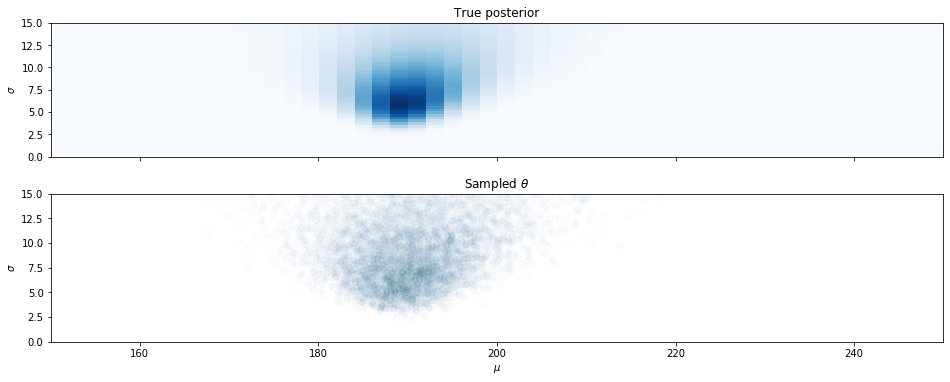

In [8]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (16, 6))
axes[0].imshow(posterior, cmap='Blues', extent=extent, aspect=1)
axes[0].set_ylabel('$\sigma$')
axes[1].scatter(trace['mu'], trace['sigma'], alpha=0.01)
axes[1].set_ylabel('$\sigma$')
axes[0].set_title('True posterior')
axes[1].set_title('Sampled $\\theta$')
plt.xlabel('$\mu$')
plt.xlim(150, mm.max())
plt.ylim(0, ss.max())

In [15]:
logging.basicConfig(format='%(message)s', level=logging.INFO)
pyro.enable_validation(__debug__)
pyro.set_rng_seed(0)

def model():
    mu = pyro.sample('mu', dist.Normal(torch.tensor(200.), torch.tensor(15.)))
    sigma = pyro.sample('sigma', dist.HalfCauchy(torch.tensor(10.)))
    return pyro.sample("obs", dist.Normal(mu,sigma))


def conditioned_model(model):
    return poutine.condition(model, data={"obs": torch.from_numpy(lengths)})()

nuts_kernel = NUTS(conditioned_model, jit_compile=False)
mcmc = MCMC(nuts_kernel,
                num_samples=10000,
                warmup_steps=500,
                num_chains=1)
mcmc.run(model)
mcmc.summary(prob=0.5)
trace = mcmc.get_samples()

Sample: 100%|██████████| 10500/10500 [01:30, 116.23it/s, step size=5.38e-01, acc. prob=0.889]



                mean       std    median     25.0%     75.0%     n_eff     r_hat
        mu    191.51      7.86    190.71    185.48    194.15   3167.16      1.00
     sigma     13.31     10.85     10.27      4.77     11.25   2759.82      1.00

Number of divergences: 0


(0, 15.0)

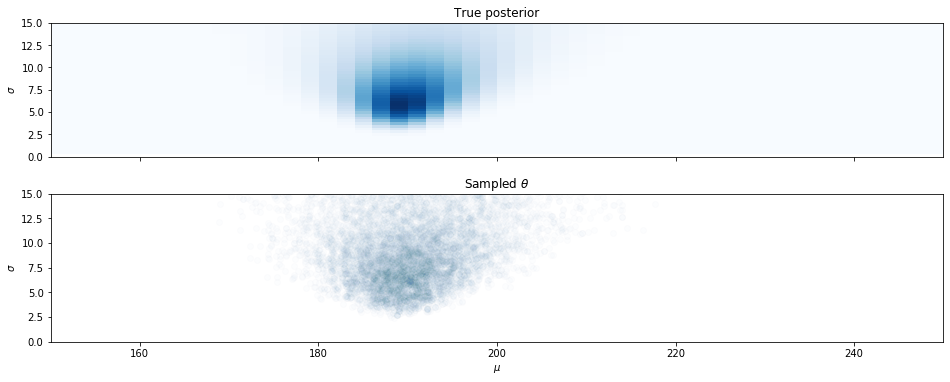

In [16]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (16, 6))
axes[0].imshow(posterior, cmap='Blues', extent=extent, aspect=1)
axes[0].set_ylabel('$\sigma$')
axes[1].scatter(trace['mu'], trace['sigma'], alpha=0.01)
axes[1].set_ylabel('$\sigma$')
axes[0].set_title('True posterior')
axes[1].set_title('Sampled $\\theta$')
plt.xlabel('$\mu$')
plt.xlim(150, mm.max())
plt.ylim(0, ss.max())

In [17]:
# Mean field approximatio nof the posterior via SVI 
def model():
    # priors
    mu = pyro.sample('mu', dist.Normal(loc=torch.tensor(200.), 
                                       scale=torch.tensor(15.)))
    sigma = pyro.sample('sigma', dist.HalfCauchy(scale=torch.tensor(10.)))
    
    # likelihood
    with pyro.plate('plate', size=2):
        pyro.sample(f'obs', dist.Normal(loc=mu, scale=sigma), 
                    obs=torch.tensor([195., 185.]))

In [ ]:
def guide():
    # variational parameters
    var_mu = pyro.param('var_mu', torch.tensor(180.))
    var_mu_sig = pyro.param('var_mu_sig', torch.tensor(5.),
                             constraint=constraints.positive)
    var_sig = pyro.param('var_sig', torch.tensor(5.))

    # factorized distribution
    pyro.sample('mu', dist.Normal(loc=var_mu, scale=var_mu_sig))
    pyro.sample('sigma', dist.Chi2(var_sig))

In [ ]:
pyro.clear_param_store()
pyro.enable_validation(True)

svi = SVI(model, guide, 
          optim=pyro.optim.ClippedAdam({"lr":0.01}), 
          loss=Trace_ELBO())

# do gradient steps
c = 0
for step in range(5000):
    c += 1
    loss = svi.step()
    if step % 100 == 0:
        print("[iteration {:>4}] loss: {:.4f}".format(c, loss))

In [ ]:
sigma = dist.Chi2(pyro.param('var_sig')).sample((10000,)).numpy()
mu = dist.Normal(pyro.param('var_mu'), pyro.param('var_mu_sig')).sample((10000,)).numpy()

In [ ]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (16, 6))
axes[0].imshow(posterior, cmap='Blues', extent=extent, aspect=1)
axes[0].set_ylabel('$\sigma$')
axes[1].scatter(mu, sigma, alpha=0.1)
axes[1].set_ylabel('$\sigma$')
axes[0].set_title('True posterior $P(\\theta|D)$')
axes[1].set_title('Approximated posterior $Q(\\theta)$')
plt.xlabel('$\mu$')
plt.xlim(150, mm.max())
plt.ylim(0, ss.max())